in system that help medical technicians classify organisms present in blood samples. However,
it was soon clear that it was going to be essential in this domain to handle the inherent uncertainty in the data being provided by the technicians about various aspects of blood samples (for example
the shape of the organism).
Additionally, the pathologist was also clear that the classificatory rules used in this domain were always associated with uncertainties.

That is, even if all the data values could be precisely determined, a range of diseases would virtually always be returned (each associated with a likelihood.)
Thus if we were to use the Experta inference engine for this task it was essential that we were able to handle uncertainties at both these levels. 

# Overview of how MYCIN Handled Uncertainty
we give a typical MYCIN rule which classifies an organism (in this instance as enterobacteriaceae):

IF the stain of the organism is gram negative

AND the morphology of the organism is rod

AND the aerobicity of the organism is aerobic

THEN the class of the organism is enterobacteriaceae with confidence 0.9

This rule has 3 conditions, and if they are all satisfied then the rule is said to be
satisfied when it reports a conclusion (the class of the organism is
enterobacteriaceae) with a confidence level of .9, on a confidence scale of -1
(totally negative) to +1 (totally positive).

An uncertainty methodology has been implemented to account for the
inherent unreliability of the data, since it is generated from answers given
by a human, thus affected by human factors such as level of attention,
degree of honesty, lack of knowledge etc.

Certainty Theory is a system that works with judgmental measures of belief and associates to every fact a certainty factor (CF).

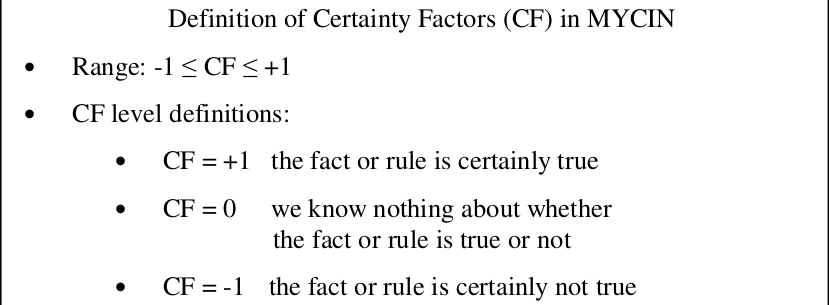

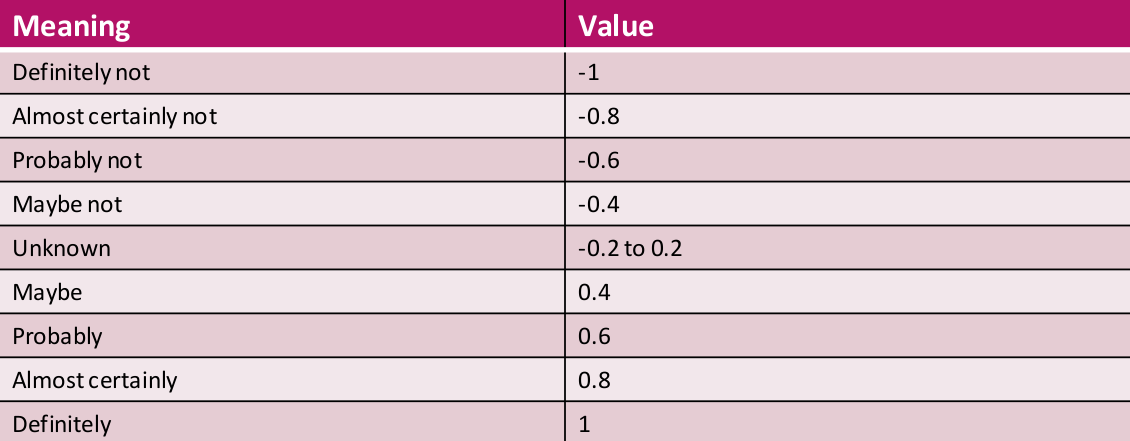

Uncertainty : Data and Rules
    
When the user inputs values which correspond to the three conditions in the rule
shown above he is asked to specify his confidence in the data which he is reporting.
Suppose the user has reached the following conclusions about the data (the organism he is analysing under a microscope):

• The stain of the organism is definitely gram negative (CF = 1.0)

• The morphology is rod, with confidence (CF = 0.8)

• The aerobicity is aerobic, with confidence (CF = 0.6)

Further, MYCIN has a procedure for calculating the CF for a conclusion of a rule on the basis of the strength of belief in the rule itself and in the various data inputs:

CF conclusion = CF rule * CF data , and

CF data = min(CF d1 , CF d2 ….. CF dn ) where the CF di are the CFs for the several data inputs

In this instance:
CF rule = 0.9

CF d1 = 1.0, CF d2 = 0.8, and CF d3 = 0.6.

So
CF conclusion = .9 * min(1.0, .8, .6)

CF conclusion = .9 * .6 = .54

Uncertainty in MYCIN: Multiple Conclusions
Not infrequently in rule bases like MYCIN’s several rules reach the same
conclusion. In fact one could argue that this is the normal situation in KBSs, where
a variety of data sources and rules are required to be considered before one is able
to reach a conclusion with any level of certainty, as generally KBSs are used in
situations where deterministic algorithms do not exist. For these reasons MYCIN
needed a mechanism to calculate the cumulative CF for a conclusion reached by
several rules. So suppose one had a KB with the following rules:
    
    Rule 1: IF A THEN B
    
    Rule 2: IF C AND D AND E THEN B

The algorithm specifies that one should:

1. Calculate the CF for each rule (i.e. each conclusion, in this case B)

2. Combine the various CFs for that conclusion, using the procedure given below:

•Suppose a rule reports a conclusion with certainty CF p and another
rule reaches the same conclusion with certainty CF n . How the
combined CF (CF comb ) is calculated depends on the signs of CF p and
CF n

• IF CF p > 0 & CF n > 0 THEN CF comb = CF p + CF n – CF p * CF n

• IF CF p < 0 & CF n < 0 THEN CF comb = CF p + CF n + CF p * CF n

• ELSE CF comb = ( CF p + CF n ) / (1 – min( abs( CF p ), abs( CF n )))

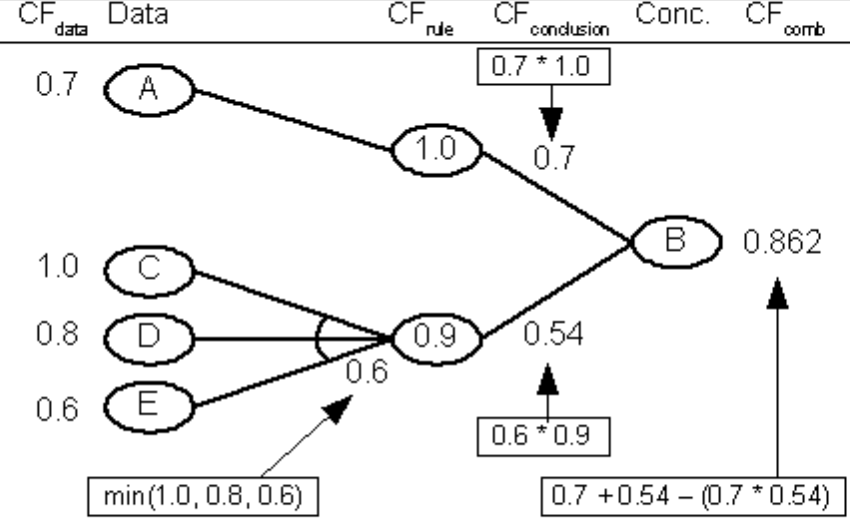

In this section we discuss how one would
implement such a rule system in Experta; initially with a simple rule which excludes
certainty factors, then one which includes them.

To implement the organism classification described previously, one is required to
provide a class which describes the data that is being observed, and the
organisms’ classifications; a series of facts which provide the details of the actual
observations; and some rules for generating classifications.
This provides a simple (deterministic) implementation for classifying organisms of
the enterobacteriaceae class, if they are of the gram negative strain, have a rod
morphology and aerobic aerobicity. This is however, only part of the story: the
example provided previously states that this classification only has a certainty of 0.9

In [ ]:
class observable(Fact):
    #The value of a property based on the clinicians observations
    name=Field(str,mandatory=True)
    value=Field(str,mandatory=True)
    
class classification(Fact):
    #The class to which the observe dorganism has been classified
    class_name=Field(str,mandatory=True)
    
class MYCIN(KnowledgeEngine):
        @DefFacts()
        def init(self):
            yield observable(name='strain',value='GramNegative')
            yield observable(name='morphology',value='rod')
            yield observable(name='aerobicity',value='aerobic')
            
        @Rule(observable(name='strain',value='GramNegative'),
             observable(name='morphology',value='rod'),
             observable(name='aerobicity',value='aerobic'), 
             )
        def enterobacteriaceae_classification(self):
            self.declare(classification(class_name='enterobacteriaceae'))

            
ke= MYCIN()
ke.reset()
ke.run()
ke.facts

To include uncertainty in the style of MYCIN into the system
we are required to make four changes:

    1. The def class for observations and classifications need to include a
    slot in which the certainty factor can be provided.
    
    2. The rule then needs to be modified to generate a certainty factor for the
    classification.
    
    3. Another rule is required which detects multiple identical conclusions and
    calls a function to calculate the certainty factor of multiple identical
    conclusions.
    
    4. A function would be useful for calculating the combined certainty factor
    of multiple conclusions.

In [4]:
class observable(Fact):
    #The value of a property based on the clinicians observations
    name=Field(str,mandatory=True)
    value=Field(str,mandatory=True)
    certainty_factor=Field(float, default=100.0)#the CF of this observable
    
class classification(Fact):
    #The class to which the observe dorganism has been classified
    class_name=Field(str,mandatory=True)
    certainty_factor=Field(float, default=100.0)#the CF of this classification
    
    
    
class combined_classification(Fact):
    #Stores the result of combining several classifications for the same class-name
    class_name=Field(str,mandatory=True)
    certainty_factor=Field(float, default=100.0)#the CF of this classification
    
    
class MYCIN(KnowledgeEngine):
        @DefFacts()
        def init(self):
            yield observable(name='strain',value='GramNegative',certainty_factor=1.0)
            yield observable(name='morphology',value='rod',certainty_factor=0.8)
            yield observable(name='aerobicity',value='aerobic',certainty_factor=0.6)
            
        @Rule(observable(name='strain',value='GramNegative',certainty_factor=MATCH.cf1),
             observable(name='morphology',value='rod',certainty_factor=MATCH.cf2),
             observable(name='aerobicity',value='aerobic',certainty_factor=MATCH.cf3), 
             )
        def enterobacteriaceae_classification(self,cf1,cf2,cf3):
            #calculate CFConclusion as 0.9 (the CF for this rule) *minimum CF of the data (stored in variables cf1, cf2 and cf3), store it in the cf variable
            cf=0.9*min(cf1,cf2,cf3)
            self.declare(classification(class_name='enterobacteriaceae',certainty_factor=cf))
            
        

            
ke= MYCIN()
ke.reset()
ke.run()
ke.facts

FactList([(0, InitialFact()),
          (1,
           observable(name='strain', value='GramNegative', certainty_factor=1.0)),
          (2,
           observable(name='morphology', value='rod', certainty_factor=0.8)),
          (3,
           observable(name='aerobicity', value='aerobic', certainty_factor=0.6)),
          (4,
           classification(class_name='enterobacteriaceae', certainty_factor=0.54))])

In [15]:
from experta import*
class observable(Fact):
    #The value of a property based on the clinicians observations
    name=Field(str,mandatory=True)
    value=Field(str,mandatory=True)
    certainty_factor=Field(float, default=100.0)#the CF of this observable
    
class classification(Fact):
    #The class to which the observe dorganism has been classified
    class_name=Field(str,mandatory=True)
    certainty_factor=Field(float, default=100.0)#the CF of this classification
    
    
    
class combined_classification(Fact):
    #Stores the result of combining several classifications for the same class-name
    class_name=Field(str,mandatory=True)
    certainty_factor=Field(float, default=100.0)#the CF of this classification
    
    
class MYCIN(KnowledgeEngine):
        @DefFacts()
        def init(self):
            yield observable(name='strain',value='GramNegative',certainty_factor=1.0)
            yield observable(name='morphology',value='rod',certainty_factor=0.8)
            yield observable(name='aerobicity',value='aerobic',certainty_factor=0.6)
            
        @Rule(observable(name='strain',value='GramNegative',certainty_factor=MATCH.cf1),
             observable(name='morphology',value='rod',certainty_factor=MATCH.cf2),
             observable(name='aerobicity',value='aerobic',certainty_factor=MATCH.cf3), 
             )
        def enterobacteriaceae_classification(self,cf1,cf2,cf3):
            #calculate CFConclusion as 0.9 (the CF for this rule) *minimum CF of the data (stored in variables cf1, cf2 and cf3), store it in the cf variable
            cf=0.9*min(cf1,cf2,cf3)
            self.declare(classification(class_name='enterobacteriaceae',certainty_factor=cf))
            
        @Rule(
          AS.f1 << classification(class_name = MATCH.name,certainty_factor= MATCH.cf1),
          AS.f2 << classification(class_name = MATCH.name,certainty_factor= MATCH.cf2),
          TEST(lambda f1,f2: f1!=f2),
           )
        def combine(self,f1,f2,cf1,cf2):
                self.retract(f1)
                cf=self.combine_cf(cf1,cf2)
                self.modify(f2,certainty_factor=cf)
        def combine_cf(self,cf1,cf2):
            #Write Code Hero
            

            
ke= MYCIN()
ke.reset()
ke.declare(classification(class_name='enterobacteriaceae',certainty_factor=0.8))
ke.run()
ke.facts

FactList([(0, InitialFact()),
          (1,
           observable(name='strain', value='GramNegative', certainty_factor=1.0)),
          (2,
           observable(name='morphology', value='rod', certainty_factor=0.8)),
          (3,
           observable(name='aerobicity', value='aerobic', certainty_factor=0.6)),
          (6,
           classification(class_name='enterobacteriaceae', certainty_factor=0.908))])

NameError: name 'cf1' is not defined

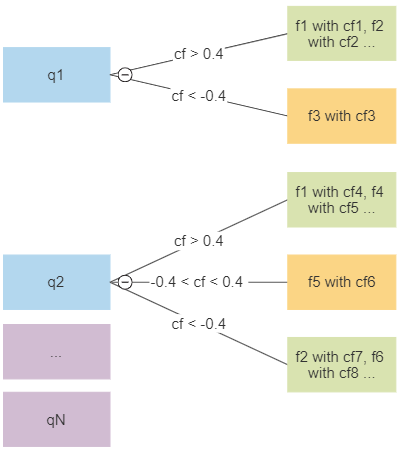

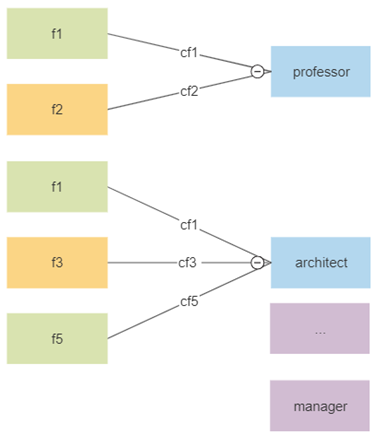

In [ ]:
from experta import *
import schema

class a_fact(Fact):
    name = Field(str, mandatory=True)
    cf = Field(float, default=100.0)

class questionnaire(Fact):
    a_fact = Field(str,mandatory=True)
    the_questionnaire= Field(str,mandatory=True)
    already_asked=Field(schema.Or(True, False),default=False)
    

    
class JOBEX(KnowledgeEngine):
    
    @DefFacts()
    def init(self):
        yield questionnaire(a_fact="Q1",
                            the_questionnaire="I spend most of my spare time actively socialising with friends, attending parties, shopping, etc. ")
        yield questionnaire(a_fact="Q2",
                            the_questionnaire="I enjoy watching and playing team sports. ")
        yield questionnaire(a_fact="Q3",
                            the_questionnaire="Being around a group of people gives me energy. ")
        yield questionnaire(a_fact="Q4",
                            the_questionnaire="I would rather cook than go eat out in a restaurant.  ")
        yield questionnaire(a_fact="good-with-computers",
                            the_questionnaire="I am very good with computers. ")
        yield questionnaire(a_fact="Q6",
                            the_questionnaire="I improvise based on my past experience rather than looking for theoretical understanding. ")
        yield questionnaire(a_fact="Q7",
                            the_questionnaire="I am comfortable working with ambiguous or incomplete information/data and guessing its meaning.")
        yield questionnaire(a_fact="Q8",
                            the_questionnaire="I like to work around targets, deadlines and routines for managing my life. ")
      
    @Rule(salience = 10000)
    def start(self):
        print(""+"\n")
        print("The JOBEX career quiz will help you decide the sort of jobs that will suit you best:"+"\n")
        print("-------------------------------------"+"\n")
        print("Accepted replies:"+"\n")
        print(" Value           Meaning "+"\n")
        print("-------------------------------------"+"\n")
        print(" -1              Definitely Not "+"\n")
        print(" -0.8            Almost certainly not "+"\n")
        print(" -0.6            Probably not "+"\n")
        print(" -0.4            Maybe not "+"\n")
        print("  0              Unknown "+"\n")
        print("  0.4            Maybe "+"\n")
        print("  0.6            Probably "+"\n")
        print("  0.8            Almost certainly "+"\n")
        print("  1              Definitely "+"\n")
        print(""+"\n")
        
        
        
    @Rule(
          AS.f << questionnaire(a_fact = MATCH.the_fact,
                                the_questionnaire=MATCH.the_question,
                                already_asked=False)
         )
    def ask_a_questionnaire(self,f,the_fact,the_question):
        self.modify(f,already_asked=True)
        accepted=[-1.0,-0.8,-0.6,-0.4,0,0.4,0.6,0.8,1.0]
        certainty=self.next_questionnaire(the_question,accepted)
        self.declare(a_fact(name=the_fact,cf=certainty))
        
    def next_questionnaire(self,questionnaire,allowed_values):
        print(questionnaire,"\n")
        print("reply: ","\n")
        try:
            reply=float(input())
        except:
            reply=10000
        
        while reply not in allowed_values:
            print(questionnaire,"\n")
            print("reply: ","\n")
            try:
                reply=float(input())
            except:reply=1000
            print("\n")
        return float(reply)
        


        
        
        
    @Rule(
        OR(
            a_fact(name = "Q1",cf= MATCH.cf1),
            a_fact(name = "likes-sports",cf= MATCH.cf1)
          )
         )
    def rule1(self,cf1):
        if cf1 >= 0.4:
            self.declare(a_fact(name="is-social",cf=0.8*cf1))
            self.declare(a_fact(name="is-active",cf=0.6*cf1))
            self.declare(a_fact(name="likes-outdoor-activities",cf=0.8*cf1))
            self.declare(a_fact(name="likes-indoor-activities",cf=0.8*cf1))
            self.declare(a_fact(name="likes-spending",cf=0.8*cf1))
        elif  cf1 <= -0.4:
            self.declare(a_fact(name="is-introvert",cf=0.6*cf1))
            self.declare(a_fact(name="likes-indoor-activities",cf=0.9*cf1))
            
            
            
    @Rule(
        AND(
            a_fact(name = "Q2",cf= MATCH.cf1),
            a_fact(name = "Q3",cf= MATCH.cf2)
          )
         )
    def rule2(self,cf1,cf2):
        cf=min(cf1,cf2)
        if cf1 >= 0.4 and cf1 >= 0.4:
            cf_=0.8*cf
            self.declare(a_fact(name="likes-sports",cf=cf_))
            cf_=0.6*cf
            self.declare(a_fact(name="is-social",cf=cf_))
            cf_=0.7*cfىخ
            self.declare(a_fact(name="is-leader",cf=cf_))
            self.declare(a_fact(name="likes-teaching",cf=cf_))

        elif  cf1 <= -0.4 and cf2<= -0.4:
            self.declare(a_fact(name="is-introvert",cf=0.6*cf))
            self.declare(a_fact(name="is-follower",cf=0.7*cf))
            
            
    @Rule(
        OR(
            a_fact(name = "Q4",cf= MATCH.cf1),
            a_fact(name = "is-social",cf= MATCH.cf1)
          )
         )
    def rule3(self,cf1):
        if cf1 >= 0.4:
            self.declare(a_fact(name="is-introvert",cf=0.9*cf1))
            self.declare(a_fact(name="is-follower",cf=0.7*cf1))
            self.declare(a_fact(name="is-leader",cf=0.7*cf1))
            cf_=-0.7*cf1
            self.declare(a_fact(name="likes-teaching",cf=cf_))

        elif  cf1 <= -0.4:
            self.declare(a_fact(name="is-active",cf=0.6*cf1))
            
            
            
    @Rule(
            a_fact(name = "good-with-computers",cf= MATCH.cf1)
         )
    def rule4(self,cf1):
        if cf1 >= 0.4:
            self.declare(a_fact(name="likes-indoor-activities",cf=0.9*cf1))
            self.declare(a_fact(name="is-follower",cf=-0.7*cf1))
            self.declare(a_fact(name="likes-outdoor-activities",cf=-0.7*cf1))

        elif  cf1 <= -0.4:
            self.declare(a_fact(name="is-active",cf=0.6*cf1))
            
            
    
    @Rule(
        AND(
            a_fact(name = "Q6",cf= MATCH.cf1),
            a_fact(name = "is-follower",cf= MATCH.cf2)
          )
         )
    def rule5(self,cf1,cf2):
        cf=min(cf1,cf2)
        if cf1 >= 0.4:
            self.declare(a_fact(name="is-active",cf=-0.3*cf))

        elif  cf1 <= -0.4:
            cf_=0.5*cf
            self.declare(a_fact(name="likes-studying",cf=cf_))
            cf_=0.7*cf
            self.declare(a_fact(name="likes-teaching",cf=cf_))

    
    
    @Rule(a_fact(name = "Q7",cf= MATCH.cf1))
    def rule6(self,cf1):
        if cf1 >= 0.4:
            cf_=0.9*cf1
            self.declare(a_fact(name="likes-studying",cf=cf_))
            cf_=0.7*cf1
            self.declare(a_fact(name="likes-teaching",cf=cf_))
            
            
    @Rule(a_fact(name ="Q8",cf= MATCH.cf1))
    def rule7(self,cf1):
        if cf1 >= 0.4:
            self.declare(a_fact(name="is-follower",cf=0.9*cf1))
            self.declare(a_fact(name="is-leader",cf=-0.9*cf1))

            
            
            
    @Rule(a_fact(name = "Q1",cf= MATCH.cf1))
    def  print_results(self,cf1):
        print("The recommended jobs for you are:"+"\n\n")
        self.declare(Fact('finished'))
        
    
    @Rule(Fact('finished'),
          a_fact(name = "is-leader",cf= MATCH.cf1),
          a_fact(name = "is-social",cf= MATCH.cf2),
         )
    def job_selection_rule_1(self,cf1,cf2):
        cf=min(cf1,cf2)
        if 0.7*cf >= 0.4:
            print("-------------------------------------"+"\n")
            print("Manager with  cf ",0.7*cf)
            print("-------------------------------------"+"\n\n")
    
    
    @Rule(Fact('finished'),
          a_fact(name = "is-social",cf= MATCH.cf1),
          a_fact(name = "is-leader",cf= MATCH.cf2),
           a_fact(name = "likes-teaching",cf= MATCH.cf3),
         )
    def job_selection_rule_2(self,cf1,cf2,cf3):
        cf=min(cf1,cf2,cf3)
        if 0.8*cf >= 0.4:
            print("-------------------------------------"+"\n")
            print("Professor with cf ",0.8*cf)
            print("-------------------------------------"+"\n\n")
            
            
    @Rule(Fact('finished'),
          a_fact(name = "likes-spending",cf= MATCH.cf1),
          a_fact(name = "likes-outdoor-activities",cf= MATCH.cf2),
          a_fact(name = "likes-sports",cf= MATCH.cf3),
         )
    def job_selection_rule_3(self,cf1,cf2,cf3):
        cf=min(cf1,cf2,cf3)
        if 0.9*cf >= 0.4:
            print("-------------------------------------"+"\n")
            print("HR Manager with cf ",0.9*cf)
            print("-------------------------------------"+"\n\n")
            
    @Rule(Fact('finished'),
              a_fact(name = "likes-indoor-activities",cf= MATCH.cf1),
              a_fact(name = "likes-studying",cf= MATCH.cf2),
              a_fact(name = "is-introvert",cf= MATCH.cf3),
              a_fact(name = "good-with-computers",cf= MATCH.cf4),
         )
    def job_selection_rule_4(self,cf1,cf2,cf3,cf4):
        cf=min(cf1,cf2,cf3,cf4)
        if 0.8*cf >= 0.4:
            print("-------------------------------------"+"\n")
            print("Computer Programmer with cf ",0.8*cf)
            print("-------------------------------------"+"\n\n")
            
            
            
            
            
            
    @Rule(Fact('finished'),
              a_fact(name = "likes-indoor-activities",cf= MATCH.cf1),
              a_fact(name = "likes-studying",cf= MATCH.cf2),
              a_fact(name = "is-leader",cf= MATCH.cf3),
         )
    def job_selection_rule_5(self,cf1,cf2,cf3):
        cf=min(cf1,cf2,cf3)
        if 0.7*cf >= 0.4:
            print("-------------------------------------"+"\n")
            print("Mathematician with cf  ",0.7*cf)
            print("-------------------------------------"+"\n\n")
            
            
    @Rule(Fact('finished'),
              a_fact(name = "is-leader",cf= MATCH.cf1),
              a_fact(name = "likes-studying",cf= MATCH.cf2),
         )
    def job_selection_rule_6(self,cf1,cf2):
        cf=min(cf1,cf2)
        if 0.8*cf >= 0.4:
            print("-------------------------------------"+"\n")
            print("Architect with  cf ",0.8*cf)
            print("-------------------------------------"+"\n\n")
            
            
    @Rule(Fact('finished'),
              a_fact(name = "is-follower",cf= MATCH.cf1),
              a_fact(name = "likes-outdoor-activities",cf= MATCH.cf2),
         )
    def job_selection_rule_7(self,cf1,cf2):
        cf=min(cf1,cf2)
        if 0.9*cf >= 0.4:
            print("-------------------------------------"+"\n")
            print("Construction Worker with cf ",0.9*cf)
            print("-------------------------------------"+"\n\n")
            

    
    @Rule(
          AS.f1 << a_fact(name = MATCH.id,cf= MATCH.cf1),
          AS.f2 << a_fact(name = MATCH.id,cf= MATCH.cf2),
          TEST(lambda f1,f2: f1!=f2),
          TEST(lambda cf1: cf1>0),
          TEST(lambda cf2: cf2>0),salience = 100
         )
    def combine_certainties_1(self,f1,f2,cf1,cf2):
        self.retract(f1)
        cf_=cf1+cf2*(1-cf1)
        self.modify(f2,cf=cf_)
        
    @Rule(
          AS.f1 << a_fact(name = MATCH.id,cf= MATCH.cf1),
          AS.f2 << a_fact(name = MATCH.id,cf= MATCH.cf2),
          TEST(lambda f1,f2: f1!=f2),
          TEST(lambda cf1: cf1<0),
          TEST(lambda cf2: cf2<0),salience = 100
         )
    def combine_certainties_2(self,f1,f2,cf1,cf2):
        self.retract(f1)
        cf_=cf1+cf2*(1+cf1)
        self.modify(f2,cf=cf_)
        
    @Rule(
          AS.f1 << a_fact(name = MATCH.id,cf= MATCH.cf1),
          AS.f2 << a_fact(name = MATCH.id,cf= MATCH.cf2),
          TEST(lambda f1,f2: f1!=f2),
          TEST(lambda cf1: cf1>0),
          TEST(lambda cf2: cf2<0),salience = 100
         )
    def combine_certainties_3(self,f1,f2,cf1,cf2):
        self.retract(f1)
        cf=min(abs(cf1),abs(cf2))
        try:
            cf_=(cf1+cf2)/(1-cf)
        except ZeroDivisionError:
            cf_=(cf1+cf2)/(1-0.05)
        self.modify(f2,cf=cf_)
        
ke= JOBEX()
ke.reset()
ke.run()



The JOBEX career quiz will help you decide the sort of jobs that will suit you best:

-------------------------------------

Accepted replies:

 Value           Meaning 

-------------------------------------

 -1              Definitely Not 

 -0.8            Almost certainly not 

 -0.6            Probably not 

 -0.4            Maybe not 

  0              Unknown 

  0.4            Maybe 

  0.6            Probably 

  0.8            Almost certainly 

  1              Definitely 



I like to work around targets, deadlines and routines for managing my life.  

reply:  



 no


I like to work around targets, deadlines and routines for managing my life.  

reply:  



 no




I like to work around targets, deadlines and routines for managing my life.  

reply:  



 no




I like to work around targets, deadlines and routines for managing my life.  

reply:  



 yes




I like to work around targets, deadlines and routines for managing my life.  

reply:  



 0.3




I like to work around targets, deadlines and routines for managing my life.  

reply:  



 yes 0.4




I like to work around targets, deadlines and routines for managing my life.  

reply:  



In [2]:
ke.facts

FactList([(0, InitialFact()),
          (9,
           questionnaire(a_fact='Q8', the_questionnaire='I like to work around targets, deadlines and routines for managing my life. ', already_asked=True)),
          (10, a_fact(name='Q8', cf=1.0)),
          (13,
           questionnaire(a_fact='Q7', the_questionnaire='I am comfortable working with ambiguous or incomplete information/data and guessing its meaning.', already_asked=True)),
          (14, a_fact(name='Q7', cf=1.0)),
          (15, a_fact(name='likes-studying', cf=0.9)),
          (17,
           questionnaire(a_fact='Q6', the_questionnaire='I improvise based on my past experience rather than looking for theoretical understanding. ', already_asked=True)),
          (18, a_fact(name='Q6', cf=1.0)),
          (20,
           questionnaire(a_fact='good-with-computers', the_questionnaire='I am very good with computers. ', already_asked=True)),
          (21, a_fact(name='good-with-computers', cf=1.0)),
          (28,
           qu

# الوظائف

1

                                لغز المزارع ومعزته (عبور النهر)


لديك ماعز وملفوف وذئب عليك أن تعبرهم النهر اي تضعهم على الضفة الأخرى ولديك قارب ,تستطيع أن تحمل معك في القارب شيئاً
واحداً فقط اي ان القارب يتسع
لإثنين فقط  المطلوب أن تعبرهم النهر اي أن تضعهم على الضفة المقابلة دون أن تترك الذئب مع الماعز لأن الذئب يأكل الماعز ودون أن تترك الماعز مع  الملفوف  لأن الماعز يأكل الملفوف

                                                                                                                                                                                                            
                                                                                        
                                                                                       لذا فقيود المشكلة هي:

                ‫كل حركة يمكن نقل شيء واحد فقط (الذئب أو الماعز أو الملفوف )من ضفة الى الضفة المقابلة    ‬
                                                          
                                                          لايمكن للذئب التواجد مع الماعز في نفس الضفة

                                                       لايمكن للماعز التواجد مع  الملفوف في نفس الضفة
 



 2
 
     البحث عن فكرة كيفية معالجة مفهوم الشك (عدم اليقين) باستخدام نظرية المنطق الضبابي ( المنطق العائم )وكتابة 
                            تفرير بسيط يبين الفكرة النظرية بشكل عام دون التطرق  لكيفية تنجيزها (مابدي كود)

In [ ]:
from experta import *
class goat(Fact):
    firstRiverSide=Field(bool,mandatory=True)
    secondRiverSide=Field(bool,mandatory=True)
    onTheBoat=Field(bool,mandatory=True)
    
class cabbage(Fact):
    firstRiverSide=Field(bool,mandatory=True)
    secondRiverSide=Field(bool,mandatory=True)
    onTheBoat=Field(bool,mandatory=True)
    
class wolf(Fact):
    firstRiverSide=Field(bool,mandatory=True)
    secondRiverSide=Field(bool,mandatory=True)
    onTheBoat=Field(bool,mandatory=True)

class farmer(Fact):
    firstRiverSide=Field(bool,mandatory=True)
    secondRiverSide=Field(bool,mandatory=True)
    onTheBoat=Field(bool,mandatory=True)
    
class farmerMystery(KnowledgeEngine):
        @DefFacts()
        def init(self):
            yield cabbage(firstRiverSide=True,secondRiverSide=False,onTheBoat=False)
            yield goat(firstRiverSide=True,secondRiverSide=False,onTheBoat=False)
            yield wolf(firstRiverSide=True,secondRiverSide=False,onTheBoat=False)
            yield farmer(firstRiverSide=True,secondRiverSide=False,onTheBoat=False)
        
        @Rule( AS.f << farmer(onTheBoat=False))
        def farmerOnTheBoat(self,f):
            self.modify(f,onTheBoat=True)
            print("first")
        
        @Rule( AS.f << farmer(firstRiverSide=True,onTheBoat=True),AS.f2 << goat(firstRiverSide=True,onTheBoat=False) )
        def firstMove(self,f,f2):
            self.modify(f,firstRiverSide=False,secondRiverSide=True)
            self.modify(f2,firstRiverSide=False,secondRiverSide=True)
            print("second")
        
        @Rule( AS.f << farmer(firstRiverSide=False,secondRiverSide=True))
        def secondMove(self,f):
            self.modify(f,firstRiverSide=True,secondRiverSide=False)
            print("third")
        
        
        @Rule( AS.f << farmer(firstRiverSide=True,onTheBoat=True),AS.f2 << cabbage(firstRiverSide=True,onTheBoat=False))
        def thirdMove(self,f,f2):
            self.modify(f,firstRiverSide=False,secondRiverSide=True)
            self.modify(f2,firstRiverSide=False,secondRiverSide=True,onTheBoat=True)
            print("fourth")
        
        @Rule( AS.f << farmer(firstRiverSide=False,secondRiverSide=True),
              AS.f2 << cabbage(firstRiverSide=False,secondRiverSide=True,onTheBoat=True)
             ,AS.f3 << goat(firstRiverSide=False,secondRiverSide=True))
        def fourthMove(self,f,f2,f3):
            self.modify(f,firstRiverSide=True,secondRiverSide=False)
            self.modify(f2,firstRiverSide=False,secondRiverSide=True,onTheBoat=False)
            self.modify(f3,firstRiverSide=True,secondRiverSide=False,onTheBoat=True)
            print("fifth")
            
        @Rule( AS.f << farmer(firstRiverSide=True,secondRiverSide=False,onTheBoat=True),
              AS.f2 << wolf(firstRiverSide=True,secondRiverSide=False,onTheBoat=False)
             ,AS.f3 << goat(firstRiverSide=True,secondRiverSide=False,onTheBoat=True))
        def fifthMove(self,f,f2,f3):
            self.modify(f,firstRiverSide=False,secondRiverSide=True)
            self.modify(f2,firstRiverSide=False,secondRiverSide=True,onTheBoat=True)
            self.modify(f3,firstRiverSide=True,secondRiverSide=False,onTheBoat=False)
            print("sixth")
            
            
        @Rule( AS.f << farmer(firstRiverSide=False,secondRiverSide=True,onTheBoat=True),
              AS.f2 << wolf(firstRiverSide=False,secondRiverSide=True,onTheBoat=True))
        def sisthMove(self,f,f2):
            self.modify(f,firstRiverSide=True,secondRiverSide=False)
            self.modify(f2,firstRiverSide=False,secondRiverSide=True,onTheBoat=False)
            print("seventhMove")
        
        @Rule( AS.f << farmer(firstRiverSide=True,secondRiverSide=False,onTheBoat=True)
             ,AS.f2 << goat(firstRiverSide=True,secondRiverSide=False,onTheBoat=False),
              cabbage(firstRiverSide=False,secondRiverSide=True,onTheBoat=False),
              wolf(firstRiverSide=False,secondRiverSide=True,onTheBoat=False)
             )
        def seventhMove(self,f,f2):
            print("eight")
            self.modify(f,firstRiverSide=False,secondRiverSide=True,onTheBoat=False)
            self.modify(f2,firstRiverSide=False,secondRiverSide=True)
        
        
        @Rule(OR(AND(goat(firstRiverSide=True,secondRiverSide=False),
              wolf(firstRiverSide=True,secondRiverSide=False),
              farmer(firstRiverSide=False,secondRiverSide=True)),
                 AND(
            goat(firstRiverSide=False,secondRiverSide=True),
              wolf(firstRiverSide=False,secondRiverSide=True),
              farmer(firstRiverSide=True,secondRiverSide=False)
            ),     AND(
            goat(firstRiverSide=False,secondRiverSide=True),
              cabbage(firstRiverSide=False,secondRiverSide=True),
              farmer(firstRiverSide=True,secondRiverSide=False)
            ),     AND(
            goat(firstRiverSide=True,secondRiverSide=False),
              cabbage(firstRiverSide=True,secondRiverSide=False),
              farmer(firstRiverSide=False,secondRiverSide=True)
            )
                )
             )
        def failed(self):
            print("baaaka , failed")
            self.halt()
        
        @Rule(goat(firstRiverSide=False,secondRiverSide=True,onTheBoat=False),
             cabbage(firstRiverSide=False,secondRiverSide=True,onTheBoat=False),
              wolf(firstRiverSide=False,secondRiverSide=True,onTheBoat=False),
              farmer(firstRiverSide=False,secondRiverSide=True,onTheBoat=False)
             )
        def solved(self):
            print("Congratulations , solved")
            self.halt()
            
ke= farmerMystery()
ke.reset()
ke.run()
ke.facts

In [22]:
from experta import *
class state(Fact):
    prevState=Field(object,mandatory=True)
    cabbage=Field(bool,mandatory=True)
    goat=Field(bool,mandatory=True)
    wolf=Field(bool,mandatory=True)
    farmer=Field(bool,mandatory=True)
    expanded=Field(bool,mandatory=True)


class farmerMystery(KnowledgeEngine):
        @DefFacts()
        def init(self):
            yield state(prevState=False,cabbage=False,goat=False,wolf=False,farmer=False,expanded=False)

            
        @Rule( AS.s << state(prevState=W(),cabbage=True,goat=True,wolf=False,farmer=False,expanded=False),
              salience=10)
        def checklose(self,s):
            self.retract(s)
            print("deleting")
            
        @Rule( AS.s1 << state(prevState=W(),cabbage=False,goat=True,wolf=True,farmer=False,expanded=False),
              salience=10)
        def checklose1(self,s1):
            self.retract(s1)
            print("deleting")

        @Rule(AS.s2 << state(prevState=W(),cabbage=False,goat=False,wolf=True,farmer=True,expanded=False),
              salience=10)
        def checklose2(self,s2):
            self.retract(s2)
            print("deleting")

        @Rule( 
                 AS.s3 << state(prevState=W(),cabbage=True,goat=False,wolf=False,farmer=True,expanded=False),
              salience=10)
        def checklose3(self,s3):
            self.retract(s3)
            print("deleting")

        @Rule(AS.s << state(prevState=MATCH.prev,cabbage=True,goat=True,wolf=True,farmer=True,expanded=False),salience=10)
        def checkWin(self,s,prev):
            print(s['prevState'])
            #farmerMystery.printawi(prev)
            #print(s)
            #self.declare(solved(fatherstate=prev,childstate=s))
            print("Congratulations , solved")
            self.halt()
        
        
        def printawi(s):
            #farmerMystery.printawi(s.prevState)
            print("alawi")
            print(s)
        
        @Rule(AS.s << state(prevState=MATCH.prevState,cabbage=False,goat=MATCH.goat,wolf=MATCH.wolf,farmer=False
                            ,expanded=False)
              ,salience=4)
        def move(self,s,goat,wolf):
            self.declare(state(prevState=s,cabbage=True,goat=goat,wolf=wolf,farmer=True,expanded=False))
            print("farmer..cabbage")
        
        @Rule(AS.s << state(prevState=MATCH.prevState,cabbage=MATCH.cabbage,goat=MATCH.goat,wolf=MATCH.wolf,farmer=MATCH.farmer
                            ,expanded=False)
              ,TEST(lambda goat,farmer : farmer==goat),salience=3)
        def move1(self,s,cabbage,goat,wolf,farmer):
            self.modify(s,expanded=True)
            self.declare(state(prevState=s,cabbage=cabbage,goat=not(goat),wolf=wolf,farmer=not(farmer),expanded=False))
            print("farmer..goat")
            
        @Rule(AS.s << state(prevState=MATCH.prevState,cabbage=MATCH.cabbage,goat=MATCH.goat,wolf=False,farmer=False
                            ,expanded=False)
              ,salience=4)
        def move2(self,s,cabbage,goat):
            self.declare(state(prevState=s,cabbage=cabbage,goat=goat,wolf=True,farmer=True,expanded=False))
            print("farmer..wolf")
        
        @Rule(AS.s << state(prevState=MATCH.prevState,cabbage=MATCH.cabbage,goat=MATCH.goat,wolf=MATCH.wolf,farmer=True
                            ,expanded=False)
              ,salience=4)
        def move3(self,s,cabbage,goat,wolf):
            self.declare(state(prevState=s,cabbage=cabbage,goat=goat,wolf=wolf,farmer=False,expanded=False))
            print("zzz..")
        
        
ke= farmerMystery()
ke.reset()
ke.run()
#ke.facts

farmer..wolf
deleting
farmer..cabbage
deleting
farmer..goat
zzz..
farmer..wolf
zzz..
deleting
farmer..cabbage
zzz..
deleting
farmer..goat
farmer..wolf
zzz..
farmer..goat
<frozendict {'prevState': <frozendict {'prevState': <frozendict {'prevState': <frozendict {'prevState': <frozendict {'prevState': <frozendict {'prevState': <frozendict {'prevState': False, 'cabbage': False, 'goat': False, 'wolf': False, 'farmer': False, 'expanded': False, '__factid__': 1}>, 'cabbage': False, 'goat': True, 'wolf': False, 'farmer': True, 'expanded': False, '__factid__': 5}>, 'cabbage': False, 'goat': True, 'wolf': False, 'farmer': False, 'expanded': False, '__factid__': 6}>, 'cabbage': True, 'goat': True, 'wolf': False, 'farmer': True, 'expanded': False, '__factid__': 9}>, 'cabbage': True, 'goat': False, 'wolf': False, 'farmer': False, 'expanded': False, '__factid__': 12}>, 'cabbage': True, 'goat': False, 'wolf': True, 'farmer': True, 'expanded': False, '__factid__': 13}>, 'cabbage': True, 'goat': False,

In [28]:
from experta import *
class State(Fact):
    cabbage=Field(bool,mandatory=True)
    goat=Field(bool,mandatory=True)
    wolf=Field(bool,mandatory=True)
    farmer=Field(bool,mandatory=True)

path = dict()

class farmerMystery(KnowledgeEngine):
    @DefFacts()
    def init(self):
        yield State(cabbage=False,goat=False,wolf=False,farmer=False)
        path[State(cabbage=False,goat=False,wolf=False,farmer=False).__factid__] = "Initial State \n"
            
    @Rule( AS.s << State(cabbage=True,goat=True,wolf=False,farmer=False),
              salience=10)
    def checklose(self,s):
        self.retract(s)
        print("deleting")
            
    @Rule( AS.s1 << State(cabbage=False,goat=True,wolf=True,farmer=False),
              salience=10)
    def checklose1(self,s1):
        self.retract(s1)
        print("deleting")

    @Rule(AS.s2 << State(cabbage=False,goat=False,wolf=True,farmer=True),
              salience=10)
    def checklose2(self,s2):
        self.retract(s2)
        print("deleting")

    @Rule(AS.s3 << State(cabbage=True,goat=False,wolf=False,farmer=True),
              salience=10)
    def checklose3(self,s3):
        self.retract(s3)
        print("deleting")
            

    @Rule(AS.s << State(cabbage=True,goat=True,wolf=True,farmer=True),salience=10)
    def checkWin(self,s):
        print("Congratulations , solved")
        self.halt()
        
        
    @Rule(AS.s << State(cabbage=MATCH.cabbage,goat=MATCH.goat,wolf=MATCH.wolf,farmer=MATCH.farmer)
              ,TEST(lambda cabbage,farmer : farmer==cabbage))
    def move(self,s:State):
        oldPath = path[s.__factid__]
        newFact:State = self.declare(State(cabbage=not(s['cabbage']),goat=s['goat'],wolf=s['wolf'],farmer=not(s['farmer'])))
        if newFact is not None:
            path[newFact.__factid__]=oldPath+"\n move cabbage and farmer"
        print("farmer..cabbage")
        
    @Rule(AS.s << State(cabbage=MATCH.cabbage,goat=MATCH.goat,wolf=MATCH.wolf,farmer=MATCH.farmer)
              ,TEST(lambda goat,farmer : farmer==goat))
    def move1(self,s:State):
        oldPath = path[s.__factid__]
        newFact:State = self.declare(State(cabbage=s['cabbage'],goat=not(s['goat']),wolf=s['wolf'],farmer=not(s['farmer'])))
        if newFact is not None:
            newPath = oldPath+"\n move goat and farmer"
            path[newFact.__factid__]=newPath
        print("farmer..goat")
        
    @Rule(AS.s << State(cabbage=MATCH.cabbage,goat=MATCH.goat,wolf=MATCH.wolf,farmer=MATCH.farmer)
              ,TEST(lambda wolf,farmer : farmer==wolf))
    def move2(self,s:State):
        oldPath = path[s.__factid__]
        newFact:State = self.declare(State(cabbage=s['cabbage'],goat=s['goat'],wolf=not(s['wolf']),farmer=not(s['farmer']))
        if newFact is not None:
            newPath = oldPath+"\n move wolf and farmer"
            path[newFact.__factid__]=newPath
        print("farmer..wolf")
        
        
    @Rule(AS.s << State(cabbage=MATCH.cabbage,goat=MATCH.goat,wolf=MATCH.wolf,farmer=MATCH.farmer))
    def move3(self,s:State):
        oldPath = path[s.__factid__]
        newFact:State = self.depath[newFact.__factid__]=oldPath+"\n move farmer"
        print("farmer..")
        
    
        
        
ke= farmerMystery()
ke.reset()
ke.run()
ke.facts

SyntaxError: invalid syntax (<ipython-input-28-adfe9ef1f4f2>, line 71)

In [2]:
from experta import *
class state(Fact):
    prevState=Field(object,mandatory=True)
    cabbage=Field(bool,mandatory=True)
    goat=Field(bool,mandatory=True)
    wolf=Field(bool,mandatory=True)
    expanded=Field(bool,mandatory=True)
    

class farmerMystery(KnowledgeEngine):
        @DefFacts()
        def init(self):
            yield state(prevState=False,cabbage=False,goat=False,wolf=False,expanded=False)

            
        @Rule( AS.s << state(prevState=W(),cabbage=True,goat=True,wolf=False,expanded=False),
              salience=10)
        def checklose(self,s):
            self.retract(s)

            
        @Rule( AS.s1 << state(prevState=W(),cabbage=False,goat=True,wolf=True,expanded=False),
              salience=10)
        def checklose1(self,s1):
            self.retract(s1)
            
        @Rule(AS.s2 << state(prevState=W(),cabbage=False,goat=False,wolf=True,expanded=False),
              salience=10)
        def checklose2(self,s2):
            self.retract(s2)
            
        @Rule( 
                 AS.s3 << state(prevState=W(),cabbage=True,goat=False,wolf=False,expanded=False),
              salience=10)
        def checklose3(self,s3):
            self.retract(s3)
        
        @Rule(state(prevState=W(),cabbage=True,goat=True,wolf=True,expanded=False),salience=12)
        def checkWin(self):
            print("Congratulations , solved")
            self.halt()
        
        
        @Rule(AS.s << state(prevState=MATCH.prevState,cabbage=MATCH.cabbage,goat=MATCH.goat,wolf=MATCH.wolf
                            ,expanded=False)
              ,salience=9)
        def move1(self,s,cabbage,goat,wolf):
            self.modify(s,expanded=True)
            #self.declare(state(prevState=s,cabbage=not(cabbage),goat=goat,wolf=wolf,expanded=False))
            self.declare(state(prevState=s,cabbage=cabbage,goat=not(goat),wolf=wolf,expanded=False))
            self.declare(state(prevState=s,cabbage=cabbage,goat=goat,wolf=not(wolf),expanded=False))
            self.declare(state(prevState=s,cabbage=not(cabbage),goat=not(goat),wolf=wolf,expanded=False))
            print("zzz..")

        @Rule(AS.s << state(prevState=MATCH.prevState,cabbage=MATCH.cabbage,goat=MATCH.goat,wolf=MATCH.wolf
                            ,expanded=False)
              ,salience=9)
        def move2(self,s,cabbage,goat,wolf):
            self.modify(s,expanded=True)
            #self.declare(state(prevState=s,cabbage=not(cabbage),goat=goat,wolf=wolf,expanded=False))
            self.declare(state(prevState=s,cabbage=cabbage,goat=not(goat),wolf=wolf,expanded=False))
            self.declare(state(prevState=s,cabbage=cabbage,goat=goat,wolf=not(wolf),expanded=False))
            self.declare(state(prevState=s,cabbage=not(cabbage),goat=not(goat),wolf=wolf,expanded=False))
            print("zzz..")     
       
       @Rule(AS.s << state(prevState=MATCH.prevState,cabbage=MATCH.cabbage,goat=MATCH.goat,wolf=MATCH.wolf
                            ,expanded=False)
              ,salience=9)
        def move3(self,s,cabbage,goat,wolf):
            self.modify(s,expanded=True)
            #self.declare(state(prevState=s,cabbage=not(cabbage),goat=goat,wolf=wolf,expanded=False))
            self.declare(state(prevState=s,cabbage=cabbage,goat=not(goat),wolf=wolf,expanded=False))
            self.declare(state(prevState=s,cabbage=cabbage,goat=goat,wolf=not(wolf),expanded=False))
            self.declare(state(prevState=s,cabbage=not(cabbage),goat=not(goat),wolf=wolf,expanded=False))
            print("zzz..") 
        
ke= farmerMystery()
ke.reset()
ke.run()
ke.facts

zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz..
zzz.

RecursionError: maximum recursion depth exceeded while calling a Python object

In [49]:
from experta import *
class vedsicolor(Fact):
    check=Field(bool,mandatory=True)
      
class sepalLength(Fact):
    val=Field(float,mandatory=False)
    
class sepalWidth(Fact):
    val=Field(float,mandatory=False)
class patelWidth(Fact):
    val=Field(float,mandatory=False)
class patelLength(Fact):
    val=Field(float,mandatory=False)
        
class mm(Fact):
    pass        

class predictor(KnowledgeEngine):
        @DefFacts()
        def init(self):
            yield mm()
            
        @Rule(NOT(vedsicolor()))
        def rule_1(self):
            s=float(input("your plant sepal length ?"))
            self.declare(sepalLength(val=s))
            s=float(input("your plant sepal width ?"))
            self.declare(sepalWidth(val=s))
            s=float(input("your plant patel width ?"))
            self.declare(patelWidth(val=s))
            s=float(input("your plant patel length ?"))
            self.declare(patelLength(val=s))
        
        @Rule(sepalLength(val=MATCH.val1),sepalWidth(val=MATCH.val2),patelWidth(val=MATCH.val3),
              patelLength(val=MATCH.val5),
              TEST(lambda val1,val2,val3,val5 : AND(OR(val1>6.3 , val2>3 , val3<=1.5 ),
                                                    OR(val2<=2.7 , val5>4 , val3>1.2 ), 
                                                    val5<=5)))
        def rule_2(self):
            print("first")
        
            
ke= predictor()
ke.reset()
ke.run()
ke.facts

your plant sepal length ?7
your plant sepal width ?2
your plant patel width ?2
your plant patel length ?2
first


FactList([(0, InitialFact()),
          (1, mm()),
          (2, sepalLength(val=7.0)),
          (3, sepalWidth(val=2.0)),
          (4, patelWidth(val=2.0)),
          (5, patelLength(val=2.0))])

In [17]:
from experta import *
class father(Fact):
    fatherName=Field(str,mandatory=True)
    sonName=Field(str,mandatory=True)
class brother(Fact):
    pass
class cousin(Fact):
    pass
class family(KnowledgeEngine):
        @DefFacts()
        def init(self):
            yield father(fatherName="mohammad",sonName="alaa")
            yield father(fatherName="mohammad",sonName="abd")
            yield father(fatherName="abd",sonName="merai")
            yield father(fatherName="alaa",sonName="mahmood")
            
        @Rule(father(fatherName=MATCH.fatherName,sonName=MATCH.sonName),
              father(fatherName=MATCH.fatherName2,sonName=MATCH.sonName2),
              TEST(lambda fatherName,fatherName2 : fatherName == fatherName2),
             TEST(lambda sonName,sonName2 :  sonName!=sonName2))
        def checkBrother(self,sonName,sonName2):
            self.declare(brother(sonName,sonName2))
            
        
              
        @Rule(brother(MATCH.fatherName,MATCH.fatherName2),
             father(fatherName=MATCH.fatherName,sonName=MATCH.sonName),
             father(fatherName=MATCH.fatherName2,sonName=MATCH.sonName2),
             TEST(lambda sonName,sonName2 : sonName!=sonName2))
        def checkCousin(self,sonName,sonName2):
            self.declare(cousin(sonName,sonName2))
              
              
ke= family()
ke.reset()
ke.run()
ke.facts

FactList([(0, InitialFact()),
          (1, father(fatherName='mohammad', sonName='alaa')),
          (2, father(fatherName='mohammad', sonName='abd')),
          (3, father(fatherName='abd', sonName='merai')),
          (4, father(fatherName='alaa', sonName='mahmood')),
          (5, brother('abd', 'alaa')),
          (6, cousin('merai', 'mahmood')),
          (7, brother('alaa', 'abd')),
          (8, cousin('mahmood', 'merai'))])